In this assignment, you will be implementing a GPT model and train it using CLM objective.
 * If you get stuck at something or need more clarrifications, you may refer to : https://github.com/karpathy/minGPT/blob/master/mingpt/model.py

 * We will be using ReLU activation function instead of GELU.

 * As usual, let us install the required libraries

 * **Note** that if you are not getting the exact loss values as mentioned in this notebook, that is absolutely fine. Just see whether your implementation overfits the given toy-and-tiny paragraph!

# Installation


In [ ]:
!pip install torchdata==0.6.0 # to be compatible with torch 2.0
!pip install portalocker==2.0.0

  Using cached torchdata-0.6.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (919 bytes)
  Using cached torch-2.0.0-cp310-cp310-manylinux1_x86_64.whl.metadata (24 kB)
  Using cached triton-2.0.0-1-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (1.0 kB)
Using cached torchdata-0.6.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.6 MB)
Using cached torch-2.0.0-cp310-cp310-manylinux1_x86_64.whl (619.9 MB)
Using cached triton-2.0.0-1-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (63.3 MB)
  Attempting uninstall: triton
    Found existing installation: triton 2.1.0
    Uninstalling triton-2.1.0:
      Successfully uninstalled triton-2.1.0
  Attempting uninstall: torch
    Found existing installation: torch 2.1.2
    Uninstalling torch-2.1.2:
      Successfully uninstalled torch-2.1.2
  Attempting uninstall: torchdata
    Found existing installation: torchdata 0.7.1
    Uninstalling torchdata-0.7.1:
      Successfully unin

* See [here](https://github.com/pytorch/text) for compatability

In [ ]:
!pip install -U torchtext==0.15.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.8 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.16.2
    Uninstalling torchtext-0.16.2:
      Successfully uninstalled torchtext-0.16.2


# Imports

In [ ]:
import torch
from torch import Tensor

import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.nn.functional import one_hot

import torch.optim as optim

#text lib
import torchtext

# tokenizer
from torchtext.data.utils import get_tokenizer

#build vocabulary
from torchtext.vocab import vocab
from torchtext.vocab import build_vocab_from_iterator

# get input_ids (numericalization)
from torchtext.transforms import VocabTransform

# get embeddings
from torch.nn import Embedding

from  pprint import pprint
from yaml import safe_load
import copy
import numpy as np

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Load the dataset for LM modeling

 * We use a simple tokenizer and put

In [ ]:
batch_size = 10

In [ ]:
class Tokenizer(object):

  def __init__(self,text):
    self.text = text
    self.word_tokenizer = get_tokenizer(tokenizer="basic_english",language='en')
    self.vocab_size = None

  def get_tokens(self):
    for sentence in self.text.strip().split('\n'):
      yield self.word_tokenizer(sentence)

  def build_vocab(self):
    v = build_vocab_from_iterator(self.get_tokens(),
                                  min_freq=1,specials=['<unk>','<start>','<end>'])
    v.set_default_index(v['<unk>']) # index of OOV
    self.vocab_size = len(v)
    return v

  def token_ids(self):
    v = self.build_vocab()
    vt = VocabTransform(v)
    num_tokens = len(self.word_tokenizer(self.text))
    max_seq_len = np.ceil(num_tokens/batch_size)
    data = torch.zeros(size=(1,num_tokens))
    data = vt(self.word_tokenizer(self.text))
    data = torch.tensor(data,dtype=torch.int64)
    return data.reshape(batch_size,torch.tensor(max_seq_len,dtype=torch.int64))



In [ ]:
text = """Best known for the invention of Error Correcting Codes, he was a true polymath who applied his mathematical and problem-solving skills to numerous disciplines.
Reflecting on the significant benefits I received from Hamming, I decided to develop a tribute to his legacy. There has not been a previous biography of Hamming, and the few articles about him restate known facts and assumptions and leave us with open questions.
One thought drove me as I developed this legacy project: An individual's legacy is more than a list of their attempts and accomplishments. Their tribute should also reveal the succeeding generations they inspired and enabled and what each attempted and achieved.
This book is a unique genre containing my version of a biography that intertwines the story "of a life" and a multi-player memoir with particular events and turning points recalled by those, including me, who he inspired and enabled.
Five years of research uncovered the people, places, opportunities, events, and influences that shaped Hamming. I discovered unpublished information, stories, photographs, videos, and personal remembrances to chronicle his life, which helped me put Hamming's
legacy in the context I wanted.The result demonstrates many exceptional qualities, including his noble pursuit of excellence and helping others. Hamming paid attention to the details, his writings continue to influence, and his guidance is a timeless gift to the world.
This biography is part of """

In [ ]:
Tk = Tokenizer(text)

In [ ]:
x_raw = Tk.token_ids()
print(x_raw.shape)

torch.Size([10, 26])


In [ ]:
# let us display the first 10 tokens of the vocabulary
v = Tk.build_vocab()
print(v.vocab.get_itos()[0:10])

['<unk>', '<start>', '<end>', ',', 'and', '.', 'the', 'a', 'of', 'to']


* Create the input_ids and Labels from the raw input sequence

In [ ]:
bs,raw_seq_len = x_raw.shape
x = torch.empty(size=(bs,raw_seq_len+2),dtype=torch.int64)
x[:,1:-1] =x_raw

# insert the index of special tokens
x[:,0] = torch.full(size=(1,batch_size),fill_value=v.vocab.get_stoi()['<start>'])
x[:,-1] = torch.full(size=(1,batch_size),fill_value=v.vocab.get_stoi()['<end>'])

# Quickly check implementation
v = Tk.build_vocab()
words = []
for idx in x[0,:]:
  words.append(v.vocab.get_itos()[idx.item()])
print(' '.join(words))

<start> best known for the invention of error correcting codes , he was a true polymath who applied his mathematical and problem-solving skills to numerous disciplines . <end>


In [ ]:
# labels are just the input_ids shifted by right
bs,seq_len = x.shape
y = torch.empty(size=(bs,seq_len),dtype=torch.int64)
y[:,0:-1] = copy.deepcopy(x[:,1:])

# ignore the index of padded tokens while computing loss
y[:,-1] = torch.full(size=(1,batch_size),fill_value=-100)

# Configuration

In [ ]:
vocab_size = Tk.vocab_size
seq_len = x.shape[1]
embed_dim = 32
dmodel = embed_dim
dq = torch.tensor(4)
dk = torch.tensor(4)
dv = torch.tensor(4)
heads = torch.tensor(8)
d_ff = 4*dmodel

In [ ]:
dmodel

32

* Define all the sub-layers (mhma,ffn) in the transformer blocks
* Seed for $W_Q,W_K,W_V,W_O$, 43, 44 and 45, 46, respectively
* Seed for ffn $W_1,W_2$,  47 and 48. There are no biases
* Seed for output layer 49

In [ ]:
class MHMA(nn.Module):
    def __init__(self, d_model, dq, dk, dv, heads):
        super(MHMA, self).__init__()

        self.d_model = d_model
        self.heads = heads
        self.dq = dq
        self.dk = dk
        self.dv = dv

        self.W_q = nn.ModuleList([
            nn.Linear(d_model, dq, bias=False)
            for _ in range(heads)
        ])
        self.W_k = nn.ModuleList([
            nn.Linear(d_model, dk, bias=False)
            for _ in range(heads)
        ])
        self.W_v = nn.ModuleList([
            nn.Linear(d_model, dv, bias=False)
            for _ in range(heads)
        ])
        self.W_o = nn.Linear(heads * dv, d_model, bias=False)

        self.attn_head_size = self.dk

    def forward(self, Q, K, V, mask=None):
        BS, T, _ = Q.shape

        head_outputs = []
        for head in range(self.heads):
            Q_head = self.W_q[head](Q)
            K_head = self.W_k[head](K)
            V_head = self.W_v[head](V)

            Q_head = Q_head.unsqueeze(1)
            K_head = K_head.unsqueeze(1)
            V_head = V_head.unsqueeze(1)

            head_outputs.append(Q_head)

        Q = torch.cat(head_outputs, dim=1)
        K = torch.cat([self.W_k[h](K).unsqueeze(1) for h in range(self.heads)], dim=1)
        V = torch.cat([self.W_v[h](V).unsqueeze(1) for h in range(self.heads)], dim=1)

        if mask is not None:
            attn_score = torch.matmul(
                F.softmax(
                    (torch.matmul(Q, torch.transpose(K, -2, -1)) + mask) / np.sqrt(self.dq),
                    dim=-1
                ),
                V
            )
        else:
            attn_score = torch.matmul(
                F.softmax(
                    torch.matmul(Q, torch.transpose(K, -2, -1)) / np.sqrt(self.dq),
                    dim=-1
                ),
                V
            )


        combined_attn = attn_score.permute(0, 2, 1, 3).contiguous().view(BS, T, -1)

        out = self.W_o(combined_attn)

        return out

In [ ]:
class FFN(nn.Module):

    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

In [ ]:
class PredictionHead(nn.Module):

    def __init__(self, d_model, num_classes, dropout=0.1):
        super().__init__()
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.decoder = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.dropout(x)
        x = self.norm(x)
        x = self.decoder(x)
        return x

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_seq_length=5000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)


        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)


        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)


In [ ]:
mask = (torch.triu(torch.ones(seq_len,seq_len)) == 1).transpose(0,1)
mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, dmodel, dq, dk, dv, d_ff, heads):
        super(DecoderLayer, self).__init__()
        self.mhma = MHMA(dmodel, dq, dk, dv, heads)  # Masked MHMA
        self.layer_norm_1 = nn.LayerNorm(dmodel)
        self.ffn = FFN(dmodel, d_ff)
        self.layer_norm_2 = nn.LayerNorm(dmodel)
        self.mask = mask

    def forward(self, dec_rep, mask):
        """
        dec_rep: (batch_size, seq_len, dmodel)
        """

        mhma_output = self.mhma(dec_rep,dec_rep, dec_rep,mask)

        x = self.layer_norm_1(dec_rep + mhma_output)


        ffn_output = self.ffn(x)

        out = self.layer_norm_2(x + ffn_output)

        return out

In [ ]:
class Embed(nn.Module):

  def __init__(self,vocab_size,embed_dim):
    super(Embed,self).__init__()
    self.embed = nn.Embedding(vocab_size, embed_dim)
    self.pe = PositionalEncoding(embed_dim)

  def forward(self,x):
    out = self.pe(self.embed(x))
    return out

In [ ]:
class Decoder(nn.Module):

  def __init__(self,vocab_size,dmodel,dq,dk,dv,d_ff,heads,num_layers=1):
    super(Decoder,self).__init__()
    self.embed_lookup = Embed(vocab_size,embed_dim)
    self.dec_layers = nn.ModuleList(copy.deepcopy(DecoderLayer(dmodel,dq,dk,dv,d_ff,heads)) for i in range(num_layers))
    self.predict = PredictionHead(dmodel,vocab_size)

  def forward(self,input_ids, mask):
    out = self.embed_lookup(input_ids)
    for dec_layer in self.dec_layers:
      out = dec_layer(out, mask)
    out = self.predict(out)

    return out

In [ ]:
model = Decoder(vocab_size,dmodel,dq,dk,dv,d_ff,heads)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [ ]:
def train(input_ids,labels,epochs=1000):
  loss_trace = []
  for epoch in range(epochs):
    out = model(input_ids, mask=mask)
    loss = criterion(out.view(-1, vocab_size), labels.view(-1))
    loss_trace.append(loss.item())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if (epoch + 1) % 1000 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

  return loss_trace

In [ ]:
# run the model for 10K epochs
loss_trace=train(x,y,10000)

Epoch [1000/10000], Loss: 0.2294
Epoch [2000/10000], Loss: 0.1474
Epoch [3000/10000], Loss: 0.1343
Epoch [4000/10000], Loss: 0.1103
Epoch [5000/10000], Loss: 0.1015
Epoch [6000/10000], Loss: 0.0991
Epoch [7000/10000], Loss: 0.0979
Epoch [8000/10000], Loss: 0.1026
Epoch [9000/10000], Loss: 0.1076
Epoch [10000/10000], Loss: 0.0942


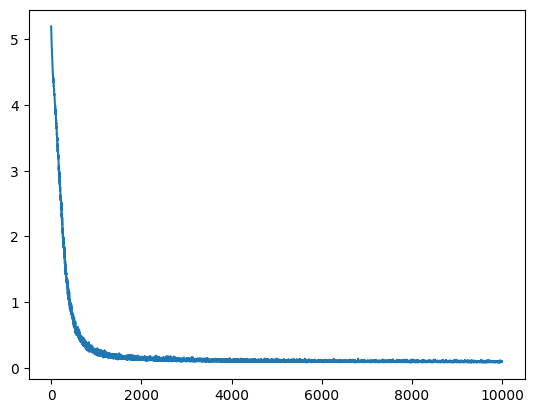

In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss_trace, label='Training Loss')

The loss is about 0.09 after 10K epochs

# Generate text

In [ ]:
prompt = "<start>"
input_ids = torch.tensor([v[token] for token in prompt], dtype=torch.long).unsqueeze(0)
model(input_ids, mask=None)

tensor([[[-0.2169,  0.1683, -3.2348,  ...,  5.5937, -4.0363,  3.4876],
         [-1.2053,  0.9998,  1.7406,  ...,  2.6023,  5.3037,  9.0182],
         [-1.4868,  0.2166, -0.4383,  ...,  3.5820, -7.5712,  1.5953],
         ...,
         [-1.3653, -0.5825,  3.8969,  ...,  5.1757, -1.3427,  4.3466],
         [-0.8232, -0.1522,  1.3065,  ...,  2.8392, -3.9416, -1.5880],
         [ 0.0392,  0.4394,  2.4611,  ...,  6.1939, -3.5262,  5.1913]]],
       grad_fn=<ViewBackward0>)

In [ ]:
@torch.inference_mode()
def generate(model, prompt='<start>', max_words=25):

    model.eval()

    input_ids = torch.tensor([v[token] for token in prompt], dtype=torch.long).unsqueeze(0)

    generated_ids = input_ids.clone()
    current_input = input_ids


    for _ in range(max_words):

        logits = model(current_input, mask=None)

        next_token_logits = logits[:, -1, :]

        next_token_id = torch.argmax(next_token_logits, dim=-1, keepdim=True)

        generated_ids = torch.cat([generated_ids, next_token_id], dim=1)

        current_input = generated_ids

        if next_token_id.item() == v['<end>']:
            break


    generated_words = [
        v.lookup_token(id.item()) for id in generated_ids[0]
        if id.item() not in [v['<start>'], v['<end>']]
    ]
    return ' '.join(generated_words)

In [ ]:
generate(model,prompt='<start>',max_words=25)

"<unk> s <unk> a <unk> <unk> <unk> research uncovered a life and personal remembrances to chronicle his life , which helped me put hamming ' s legacy"

* Note the model has memorized the sentence from the training set. Given the start token, if your implementation reproduce a sentence as is in the training set, then your implementation is likely to be correct.
* Suppose the prompt is `<start> best known`, then we expect the model to produce the first sentence as is

In [ ]:
generate(model,prompt=['<start>','best','known'],max_words=25)

'best known for the invention of error correcting codes , he was a true polymath who applied his mathematical and problem-solving skills to numerous disciplines .'

* Change the prompt

In [ ]:
generate(model,prompt=['<start>','reflecting','on'],max_words=25)

'reflecting on the significant benefits i received from hamming , i decided to develop a tribute to his legacy . there has not been a previous'